# Keyboard SMASH

In [79]:
from collections import Counter
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial

In [80]:
def get_monostring(path):
    with open(path) as fi:
        lines = [line.strip() for line in fi.readlines()]
        return "".join(lines)

def to_normvector(monostring, alphabet):
    counts = Counter(monostring)
    vector = np.array([counts[c] for c in alphabet])
    normvector = vector/vector.sum()    
    return normvector 

## Frequency distributions

Alphabet:   $ ' + , - . 0 2 3 4 5 6 7 8 9 < A L a b c d e f ...


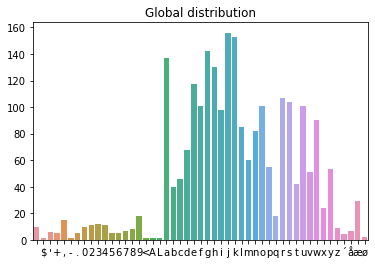

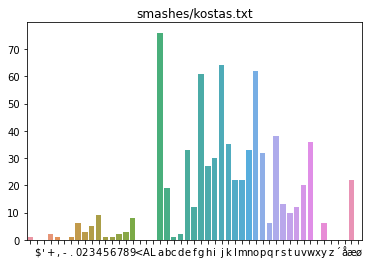

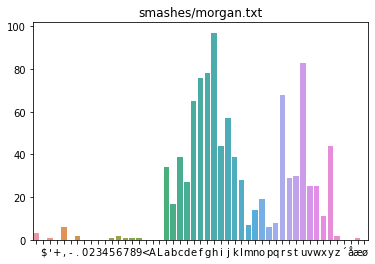

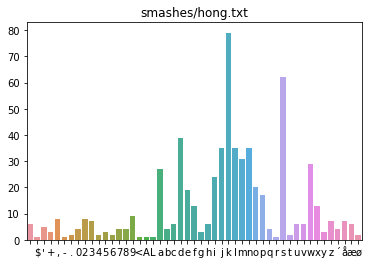

In [81]:
# gather data
pairs = [(path, get_monostring(path)) for path in glob.glob('smashes/*.txt')]
paths, monostrings = zip(*pairs)

allstring = "".join([ms for ms in monostrings])
alphabet = sorted(list(set(list(allstring))))

#for path, df in dfs:
#    x, y = get_occurs(df)
#    print(path)
#    sns.barplot(x=x, y=y)
#    plt.
print('Alphabet:', " ".join(alphabet[:25] + ['...']))

# global distribution
counts = Counter(allstring)
sns.barplot(x=alphabet, y=[counts[c] for c in alphabet])
plt.title('Global distribution')
plt.show()

# individual distributions
for path, monostring in pairs:
    counts = Counter(monostring)
    sns.barplot(x=alphabet, y=[counts[c] for c in alphabet])
    plt.title(path)
    plt.show()

# Why is most normal?

In [82]:
global_normvector = to_normvector(allstring, alphabet)
normvectors = [to_normvector(ms, alphabet) for ms in monostrings if len(ms)]
tree = spatial.KDTree(normvectors)

In [84]:
dist, idx = tree.query(global_normvector)
paths[idx]

'smashes/kostas.txt'